In [13]:
import os
import glob
from tqdm import tqdm

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import silence_tensorflow.auto
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = 1
config.gpu_options.per_process_gpu_memory_fraction = 1
session = tf.compat.v1.InteractiveSession(config=config)

# tf.debugging.enable_check_numerics()

import keras
import random
import numpy as np
import matplotlib.pyplot as plt

I0000 00:00:1738607254.230292   26586 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3794 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [14]:
H = 128
W = 128
C = 3

P = 4
assert(H == W)
assert(H % P == 0)


h = 8

D_model = 256
D_head = 64
D_fcn = 1024
num_layers = 6
N = (H * W) // (P * P)
BATCH_SIZE = 8
FLOAT = tf.float32

In [15]:
def viz_img(img):
    img = tf.cast(img, tf.float32)
    plt.imshow(tf.squeeze(img).numpy(), cmap="gray")
    plt.colorbar()
    plt.show()


def viz_mask(mask):
    plt.imshow(tf.squeeze(mask).numpy(), cmap="gray", vmin=0, vmax=1)
    plt.colorbar()
    plt.show()

In [16]:
def random_visibility_mask():
    x1 = tf.random.uniform(shape=(), minval=0, maxval=W - 100, dtype=tf.int32)
    y1 = tf.random.uniform(shape=(), minval=0, maxval=H - 100, dtype=tf.int32)
    x2 = tf.random.uniform(shape=(), minval=x1 + 50, maxval=W + 1, dtype=tf.int32)
    y2 = tf.random.uniform(shape=(), minval=y1 + 50, maxval=H + 1, dtype=tf.int32)
    # tf.print(x1,x2,y1,y2)

    mask = tf.ones((H, W), dtype=tf.bool)
    mask = tf.tensor_scatter_nd_update(
        mask,
        indices=tf.stack(
            [
                tf.repeat(tf.range(y1, y2), x2 - x1),
                tf.tile(tf.range(x1, x2), [y2 - y1]),
            ],
            axis=-1,
        ),
        updates=tf.zeros([(y2 - y1) * (x2 - x1)], dtype=tf.bool),
    )
    return tf.expand_dims(mask, -1)  # expand channel wise


ds_shape_advertised = (512, 512, 3)

def load_and_validate(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_image(img, channels=C, expand_animations=False)
    img = tf.divide(tf.cast(img, dtype=FLOAT), 255.0)
    is_valid = tf.reduce_all(tf.equal(tf.shape(img), tf.constant(ds_shape_advertised)))

    return img, is_valid


dataset_path = "/mnt/Data/ML/datasets/portraits"
num_samples = 500


all_files = [
    os.path.join(dataset_path, f)
    for f in os.listdir(dataset_path)
    if f.endswith((".jpg", ".png"))
]
random.shuffle(all_files)
selected_files = all_files[:num_samples]
dataset = tf.data.Dataset.from_tensor_slices(selected_files)
dataset = dataset.map(load_and_validate)
dataset = dataset.filter(lambda img, is_valid: is_valid)
dataset = dataset.map(lambda img, is_valid: img) 
dataset = dataset.map(lambda img: tf.image.resize(img, (H, W)))

with tf.device("/cpu:0"):
    valid_count = dataset.reduce(
        tf.constant(0, dtype=tf.int32), lambda x, _: x + 1
    ).numpy() # type: ignore

print(f"Valid images count: {valid_count}")
assert valid_count, "Everything's gone"

masks = [random_visibility_mask() for _ in range(valid_count)]
mask_dataset = tf.data.Dataset.from_tensor_slices(masks)

ds_masks = tf.data.Dataset.zip((dataset,mask_dataset))

train_count = int(valid_count * 0.8)
test_count = int(valid_count * 0.1)
val_count = valid_count - train_count - test_count

train_ds = ds_masks.take(train_count).batch(BATCH_SIZE)
test_ds = ds_masks.skip(train_count).take(test_count).batch(BATCH_SIZE)
val_ds = ds_masks.skip(train_count + test_count).take(val_count).batch(BATCH_SIZE)

train_batches = -(train_count // -BATCH_SIZE)
test_batches =  -(test_count // -BATCH_SIZE)
val_batches =  -(val_count // -BATCH_SIZE)

print("T,T,V:",train_count, test_count, val_count)

Valid images count: 500
T,T,V: 400 50 50


In [17]:
def extract_patches(image: tf.Tensor) -> tf.Tensor:
    "R^{BS x H x W x C} -> R^{BS x N x P^2 x C}"

    patches: tf.Tensor = tf.image.extract_patches(
        images=image,
        sizes=[1, P, P, 1],  
        strides=[1, P, P, 1], 
        rates=[1, 1, 1, 1], 
        padding="VALID",
    )
    BS, H_prime, W_prime, _ = tf.unstack(tf.shape(patches))

    # Reshape patches to [BS, H' * W', P*P, C]
    patches = tf.reshape(patches, [BS, H_prime * W_prime, P * P, -1])

    return patches


def patches_to_imgs(patches: tf.Tensor) -> tf.Tensor:
    "R^{BS x N x (P^2.C)} -> R^{BS x H x W x C}"
    BS = tf.shape(patches)[0]
    grid_size = H // P  # same as W // P
    patches = tf.reshape(patches, [BS, grid_size, grid_size, P, P, C])
    patches = tf.transpose(patches, perm=[0, 1, 3, 2, 4, 5])
    image = tf.reshape(patches, [BS, grid_size * P, grid_size * P, C])

    return image

    
sample = tf.expand_dims(next(iter(dataset.take(1))), 0)
tf.assert_equal(patches_to_imgs(extract_patches(sample)) , sample)

def create_attention_mask(obvmask: tf.Tensor):
    "R^{BS x H x W} -> R^{BS x N x N}"
    # TF does not support native min pooling.
    # The mask shown is OBSERVATION MASK meaning 0 means missing.

    BS = tf.shape(obvmask)[0]
    mask_pooled = tf.nn.max_pool2d(
        tf.cast(
            tf.logical_not(obvmask), dtype=tf.int8
        ),
        ksize=[P, P],
        strides=[P, P],
        padding="VALID",
    )
    mask_pooled = tf.logical_not(tf.cast(mask_pooled, tf.bool))
    # viz_mask(mask_pooled)
    mask_pooled = tf.reshape(mask_pooled, [BS, N])
    mask_expanded = tf.expand_dims(mask_pooled, axis=1)  # (BS, 1, N)
    mask_expanded = tf.tile(mask_expanded, [1, N, 1])  # (BS, N, N)
    A = tf.where(
        mask_expanded,
        tf.constant(0.0, dtype=FLOAT),  # zero penanly
        tf.constant(-float("inf"), dtype=FLOAT),  # inf penalty
    )
    return A

# create_attention_mask(tf.expand_dims(random_visibility_mask(),0))

In [25]:
commonDense = {"dtype": FLOAT, "kernel_initializer": "glorot_uniform"}

class PatchEmbedding(keras.layers.Layer):
    def __init__(self):
        super().__init__(dtype=FLOAT)
        self.proj = keras.layers.Dense(D_model, **commonDense)  # (P² * C) -> D_model

    def build(self, input_shape):
        self.positional_embedding = self.add_weight(
            shape=(N, D_model),
            initializer='glorot_uniform',
            name='pos_embed'
        )

    def call(self, patches_flat: tf.Tensor):
        # R^{BS x N x (P^2 . C)} -> R^{BS x N x D_model}
        X = self.proj(patches_flat)
        X += self.positional_embedding
        return X


class MultiHeadAttention(keras.layers.Layer):
    def __init__(self):
        super().__init__(dtype=FLOAT)
        # Project to h * D_head dimensions
        self.W_Q = keras.layers.Dense(h * D_head, **commonDense)
        self.W_K = keras.layers.Dense(h * D_head, **commonDense)
        self.W_V = keras.layers.Dense(h * D_head, **commonDense )
        # Project back to D_model
        self.W_O = keras.layers.Dense(D_model, **commonDense)

    def call(self, X, A):
        # X: R^{BS x N x D_model}
        # A: R^{BS x N x N}
        # returns: R^{BS x N x D_model}

        # In the standard implementation, each head has its own separate projection matrices. However, a common optimization is to project the input into h * D_head dimensions (which is D_model) with a single large projection, then split into h heads. So, if D_model = h * D_head, then using a Dense(D_model) for Q, K, V and then splitting into h heads each of D_head is equivalent to having h separate projections. This is a standard approach because it's more efficient to compute all heads in parallel with a single matrix multiplication rather than h separate ones.
        # So the optimal way is to use combined projections.
        Q = self.W_Q(X)  # (BS, N, h * D_head)
        K = self.W_K(X)  # (BS, N, h * D_head)
        V = self.W_V(X)  # (BS, N, h * D_head)

        Q = tf.reshape(Q, (-1, N, h, D_head))  # (BS, N, h, D_head)
        K = tf.reshape(K, (-1, N, h, D_head))
        V = tf.reshape(V, (-1, N, h, D_head))

        # Transpose for attention computation
        Q = tf.transpose(Q, [0, 2, 1, 3])  # (BS, h, N, D_head)
        K = tf.transpose(K, [0, 2, 1, 3])
        V = tf.transpose(V, [0, 2, 1, 3])
        # scaled dot-product attention
        attn_scores = tf.matmul(Q, K, transpose_b=True)  # (BS, h, N, N)
        attn_scores /= tf.math.sqrt(
            tf.cast(D_head, attn_scores.dtype)
        )  # scale by sqrt(D_head)

        A = tf.expand_dims(A, 1)  # (BS, 1, N, N)
        attn_scores += A  # Broadcast to all heads

        attn_weights = tf.nn.softmax(attn_scores, axis=-1)  # (BS, h, N, N)

        output = tf.matmul(attn_weights, V)  # (BS, h, N, D_head)
        output = tf.transpose(output, [0, 2, 1, 3])  # (BS, N, h, D_head)
        output = tf.reshape(output, (-1, N, h * D_head))  # (BS, N, h * D_head)
        output = self.W_O(output)  # (BS, N, D_model)
        return output


class TransformerBlock(keras.layers.Layer):
    def __init__(self):
        super().__init__(dtype=FLOAT)
        self.attn = MultiHeadAttention()
        self.norm1 = keras.layers.LayerNormalization(dtype=FLOAT)
        self.norm2 = keras.layers.LayerNormalization(dtype=FLOAT)
        self.ffn = keras.Sequential([
            keras.layers.Dense(D_fcn, activation='relu', **commonDense),  # Switched to ReLU
            keras.layers.Dense(D_model, **commonDense),
        ])

    def call(self, X, A):
        "R^{N x D_model} -> R^{N x D_model}"

        # NEW : pre norm blocks
        X_norm = self.norm1(X)
        X_attn = self.attn(X_norm, A)
        X = X + X_attn
        X_norm2 = self.norm2(X)
        X_ffn = self.ffn(X_norm2)
        X = X + X_ffn
        return X



# class TransformerDecoder(keras.layers.Layer):
#     def __init__(self):
#         super().__init__()
#         self.decoder = keras.Sequential([
#             keras.layers.Dense(D_model * 2, activation='gelu'),
#             keras.layers.Dense(P*P*C * 2),
#             keras.layers.Reshape((H//P, W//P, P*2, P*2, C)),
#             keras.layers.Permute((1, 3, 2, 4, 5)),  # (BS, H/p, p*2, W/p, p*2, C)
#             keras.layers.Reshape((H*2, W*2, C)),
#             keras.layers.Conv2D(128, 3, padding='same', activation='gelu'),
#             keras.layers.Conv2D(C, 3, padding='same', activation='sigmoid')
#         ])

#     def call(self, X):
#         return self.decoder(X)


class Refiner(keras.layers.Layer):
    def __init__(self):
        super().__init__(dtype=FLOAT)
        self.conv1 = keras.layers.Conv2D(64, 3, padding='same', activation='relu')
        self.conv2 = keras.layers.Conv2D(128, 3, dilation_rate=2, padding='same', activation='relu')
        self.conv3 = keras.layers.Conv2D(3, 3, padding='same')

    def call(self, X):
        "R^{BS x H x W x C} -> R^{BS x H x W x C}"
        residual = X
        X = self.conv1(X)
        X = self.conv2(X)  # Dilated conv for wider context
        X = self.conv3(X)
        return X + residual 
        
        

class TransformerDecoder(keras.layers.Layer):
    def __init__(self):
        super().__init__(dtype=FLOAT)
        self.decoder_layers = [
            keras.layers.Dense(D_model, activation='gelu'),
            keras.layers.LayerNormalization(epsilon=1e-6),
            keras.layers.Dropout(0.1)
        ] * 100
        self.projection = keras.layers.Dense(P * P * C, activation=None)

    def call(self, X):
        "R^{BS x N x D_model} -> R^{BS x N x (P^2.C)}"
        BS = tf.shape(X)[0]
        for layer in self.decoder_layers:
            X = layer(X) 

        X = self.projection(X)  # Shape: (BS, N, P*P*C)
        X = tf.reshape(X, (BS, N, P, P, C))  # Shape: (BS, N, P, P, C)
        return X

        
        


class ImageInpaintingTransformer(keras.Model):
    def __init__(self):
        super().__init__(dtype=FLOAT)
        self.embed = PatchEmbedding()
        self.transformer_blocks = [TransformerBlock() for _ in range(num_layers)]
        self.decoder = TransformerDecoder()
        self.refiner = Refiner()

    def build(self, input_shape):
        BS = input_shape[0]
        # dummy_images = tf.zeros((BS, H, W, C), dtype=FLOAT)  # THIS WASTED 40 MINUTES
        self.call(*next(iter(val_ds.take(1))))
        self.built = True

    def call(self, image, obvmask):
        image = tf.multiply(image, tf.cast(obvmask, FLOAT))
        # viz_img(image[0])
        patches = extract_patches(image)
        AttnMask = create_attention_mask(obvmask)
        # viz_img(AttnMask[0])

        BS = tf.shape(patches)[0]
        patches_flat = tf.reshape(patches, [BS, N, P**2 * C])
        # tf.print(tf.shape(patches_flat))
        X = self.embed(patches_flat)
        for block in self.transformer_blocks:
            X = block(X, AttnMask)
        
        # return self.decoder(X)
        reconstructed_patches = self.decoder(X)
        raw_reconstr = patches_to_imgs(reconstructed_patches)
        # return raw_reconstr
        return self.refiner(raw_reconstr)

model = ImageInpaintingTransformer()
model.build((BATCH_SIZE, H, W, C))
model.summary()

Model: "image_inpainting_transformer_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ patch_embedding_3               │ ?                      │       274,688 │
│ (PatchEmbedding)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_18            │ ?                      │     1,052,672 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_19            │ ?                      │     1,052,672 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_20            │ ?                      │     1,052,672 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_21            │ ?                      │     1,052,672 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_22            │ ?                      │     1,052,672 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_23            │ ?                      │     1,052,672 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_decoder_3           │ ?                      │        78,640 │
│ (TransformerDecoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ refiner_2 (Refiner)             │ ?                      │        79,107 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,748,467 (25.74 MB)

 Trainable params: 6,748,467 (25.74 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# name = "decoder_unet_1.keras"
# model.load_weights(name)
# model.save(name)

In [20]:
session_epochs = 0

In [21]:
@tf.function
def costfunc(y_true: tf.Tensor, y_pred: tf.Tensor, obsvmask: tf.Tensor):
    errors = tf.square(tf.subtract(y_true, y_pred))
    inpaintmask = tf.cast(tf.logical_not(obsvmask), FLOAT)
    masked_errors = tf.multiply(errors, inpaintmask)
    sum_masked_errors = tf.reduce_sum(masked_errors)
    area = tf.reduce_sum(inpaintmask)
    masked_loss = sum_masked_errors / (area + keras.backend.epsilon())

    global_loss = tf.reduce_mean(errors)
    return masked_loss + global_loss
    # return masked_loss


# optimizer = keras.optimizers.AdamW(
#     learning_rate=3e-4,
#     weight_decay=0.05,
#     clipvalue=1.0
# )
optimizer = keras.optimizers.Adam(learning_rate=1e-5)

@tf.function
def train_step(image: tf.Tensor, mask: tf.Tensor):
    with tf.GradientTape() as tape:
        reconstructed_img = model(image, mask)  # N x P x P x C
        loss = costfunc(image, reconstructed_img, mask)
        tf.debugging.check_numerics(loss, "Loss contains NaN or Inf.")
        # if (tf.math.is_nan(loss)):
        # raise Exception("Divergence")
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

@tf.function
def val_step(image: tf.Tensor, mask: tf.Tensor):
    reconstructed_img = model(image, mask, training=False)
    loss = costfunc(image, reconstructed_img, mask)
    return loss


epochs = 50

print("Starting training")

best_val_loss = float("inf")
best_epoch = -1
for _ in range(epochs):
    epoch_loss = 0.0
    steps = 0
    pbar = tqdm(
        train_ds,
        desc=f"Epoch {session_epochs+1}",
        unit="batch",
        total=train_batches,
    )
    for image_batch, mask_batch in pbar:
        loss = train_step(image_batch, mask_batch)
        epoch_loss += loss
        steps += 1
        # Dynamically update the tqdm bar without spamming stdout
        pbar.set_postfix(loss=f"{loss:.4f}")
    train_loss = epoch_loss / steps

    val_loss_total = 0.0
    val_steps = 0
    pbar_val = tqdm(
        val_ds,
        desc=f"Epoch {session_epochs+1} Validation",
        unit="batch",
        total=val_batches,
    )
    for val_image_batch, val_mask_batch in pbar_val:
        loss = val_step(val_image_batch, val_mask_batch)
        val_loss_total += loss
        val_steps += 1
        pbar_val.set_postfix(loss=f"{loss:.4f}")
        
    avg_val_loss = val_loss_total / val_steps
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_epoch = session_epochs + 1
        model.save("best_run.keras")
    print(
        f"Epoch {session_epochs+1} Summary: Train Loss = {train_loss:.4f} | Validation Loss = {avg_val_loss:.4f}"
    )
    session_epochs += 1

Starting training


Epoch 1 Validation: 100%|██████████| 7/7 [00:03<00:00,  2.04batch/s, loss=1.7828]


Epoch 1 Summary: Train Loss = 6.3675 | Validation Loss = 1.3258


Epoch 2:  58%|█████▊    | 29/50 [00:12<00:09,  2.27batch/s, loss=1.1109]


KeyboardInterrupt: 

In [22]:
def apply_obsv_mask(image: tf.Tensor, obvmask: tf.Tensor) -> tf.Tensor:
    return tf.multiply(image, tf.cast(obvmask, FLOAT))


def viz_grid(batch: tf.Tensor, max: int = 4):
    batch_size: int = batch.shape[0]  # type: ignore
    num = min(batch_size, max)
    fig, axes = plt.subplots(nrows=1, ncols=num, figsize=(15, 15), dpi=300)
    if num == 1:
        axes = [axes]
    for i in range(num):
        # Original image
        axes[i].imshow(
            tf.clip_by_value(
                tf.cast(batch[i], dtype=tf.float32), 0, 1  # type: ignore
            ).numpy() # type: ignore
        )
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()


def reconstruct(original: tf.Tensor, reconstruct: tf.Tensor, obvmask: tf.Tensor):
    return tf.add(
        tf.multiply(tf.cast(obvmask, FLOAT), original),
        tf.multiply(tf.cast(tf.logical_not(obvmask), FLOAT), reconstruct),
    )

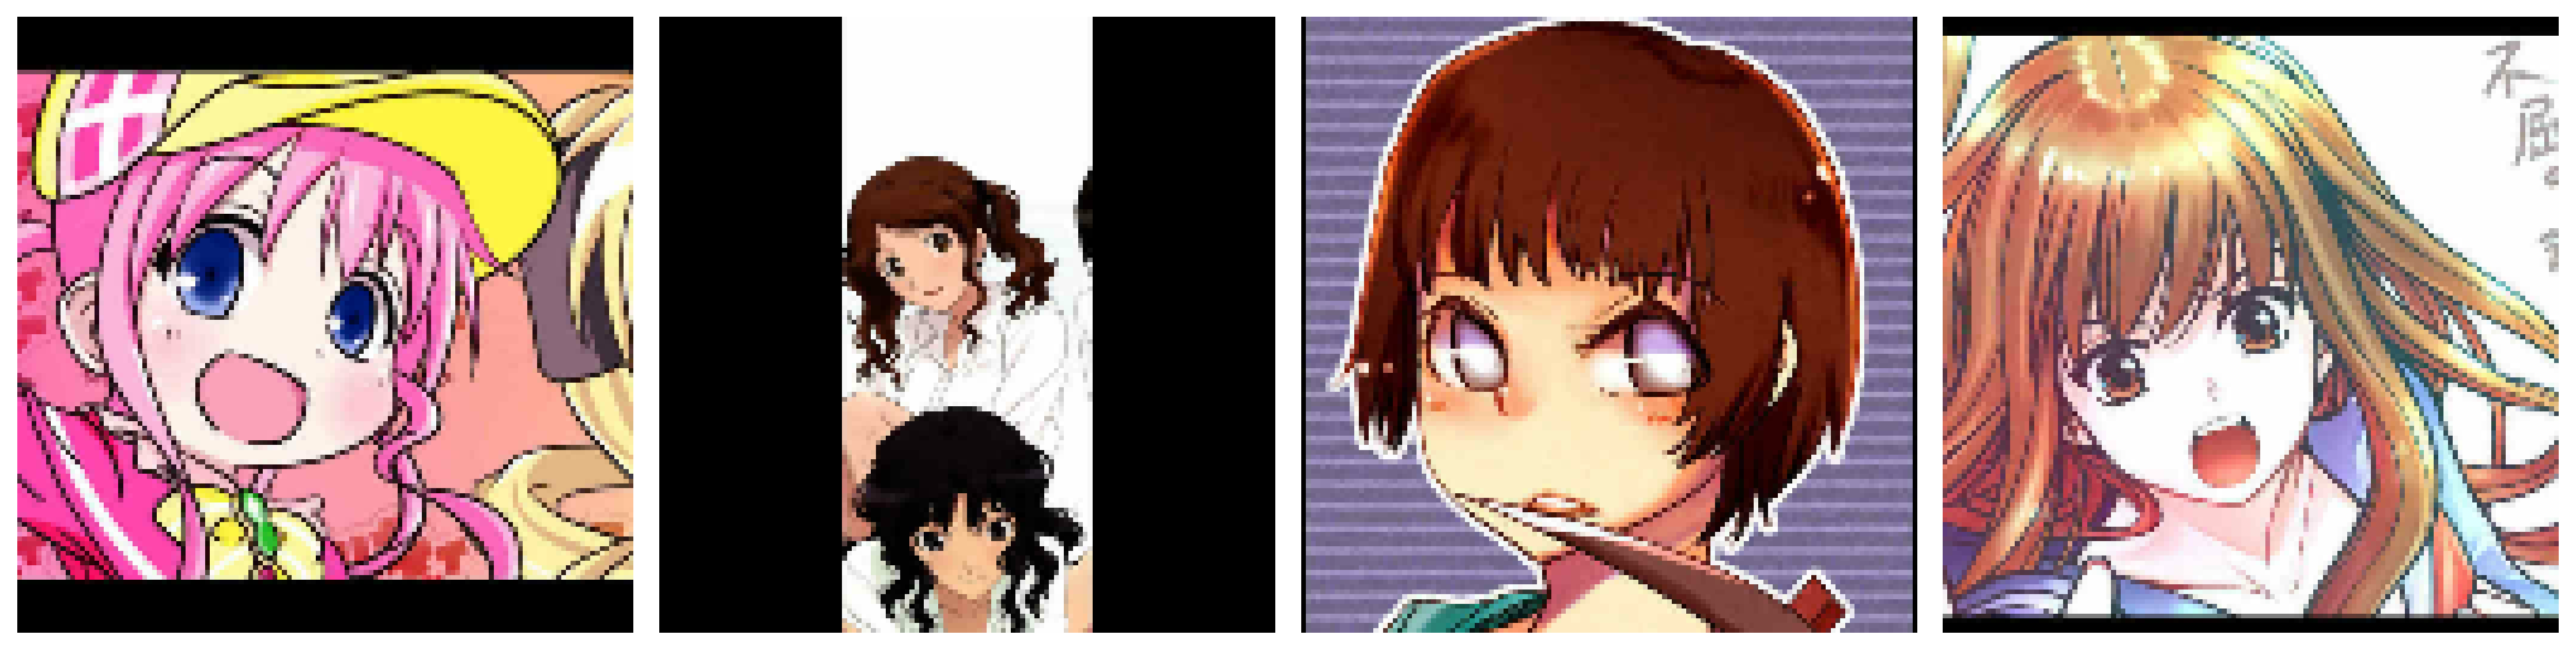

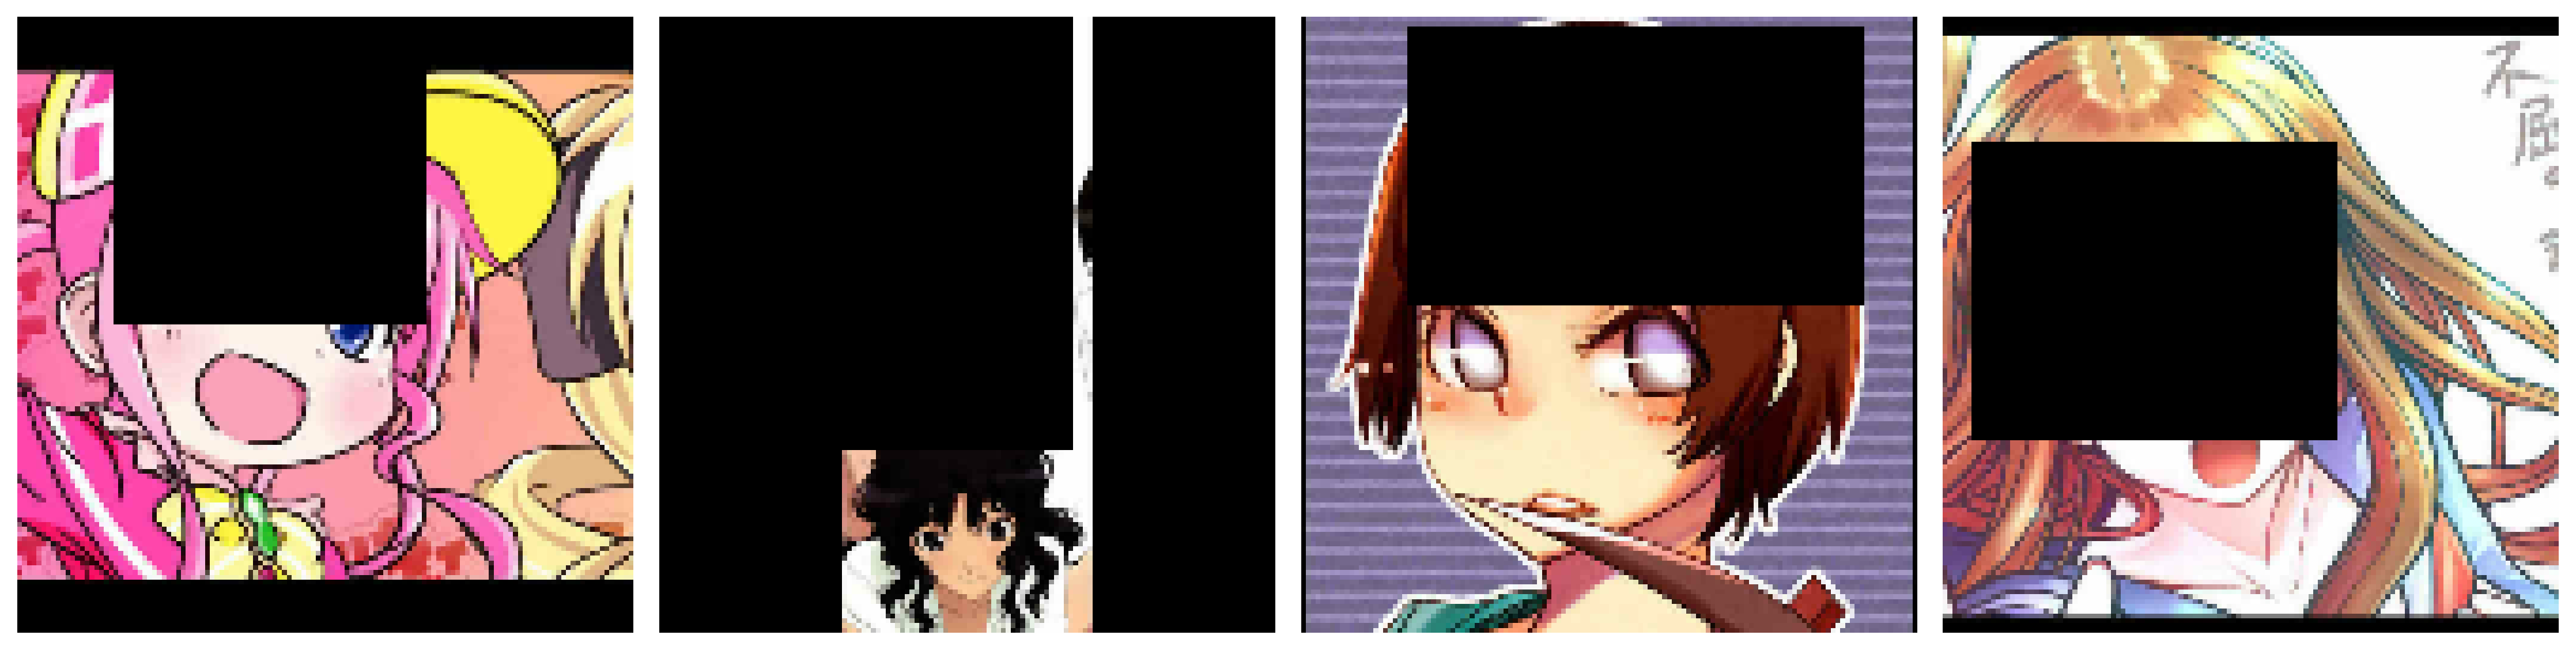

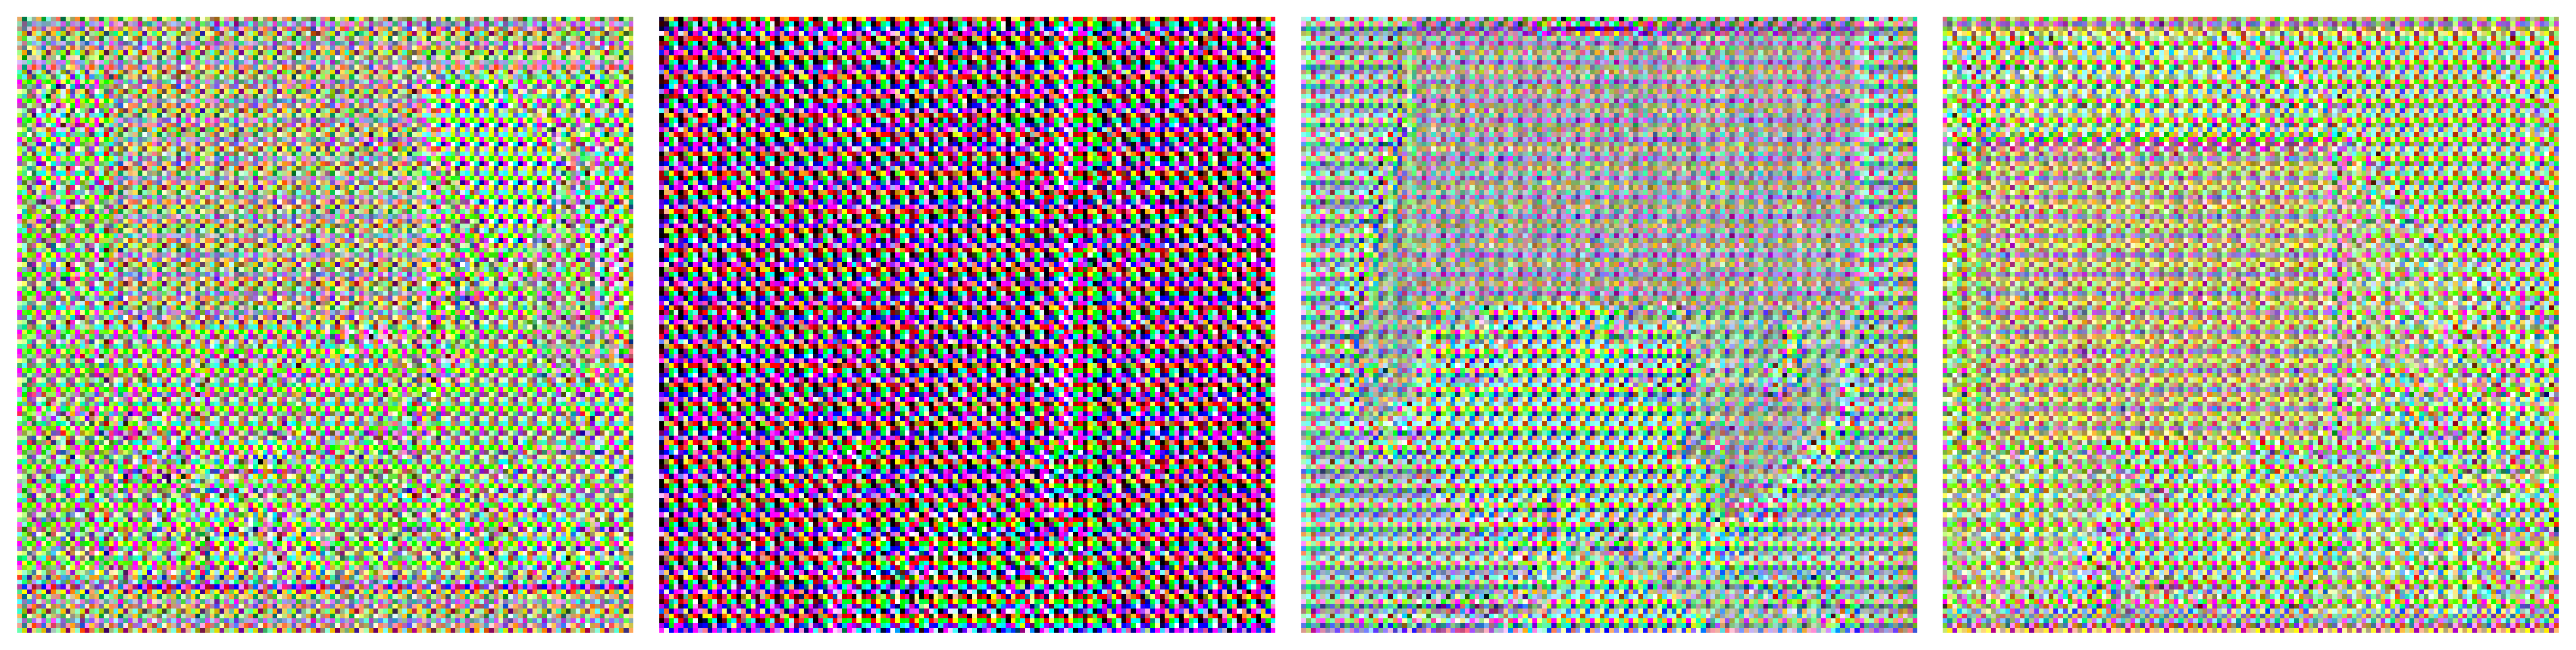

In [23]:
img, obvmask = next(iter(train_ds.take(1)))
viz_grid(img)
viz_grid(apply_obsv_mask(img, obvmask))
model_out = model(img, obvmask)
# reconstructed = reconstruct(img, model(img, obvmask), obvmask)
viz_grid(model_out)

# viz_img(model_out[0])
# viz_img(img[0])

In [12]:
# Qualitative Eval
# visualize_unbatched_dataset(test_ds, 5)


# img = tf.image.decode_image(
#     tf.io.read_file("/home/navid/Dev/PaperTex/impl/naruto")
#     , dtype=tf.float32)
# img = tf.image.resize_with_crop_or_pad(img, H, W)
# img = tf.expand_dims(img, 0)
# tf.print(tf.shape(img))
# obvmask = tf.expand_dims(random_visibility_mask(),0)
# tf.print(tf.shape(obvmask))

